# [0] Loading data

In [1]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
DATA_DIR = "./dataset/rf_dataset_yolov11_with_mask/"

x_train_dir = os.path.join(DATA_DIR, "train", "images")
y_train_dir = os.path.join(DATA_DIR, "train", "masks")

x_valid_dir = os.path.join(DATA_DIR, "valid", "images")
y_valid_dir = os.path.join(DATA_DIR, "valid", "masks")

x_test_dir = os.path.join(DATA_DIR, "test", "images")
y_test_dir = os.path.join(DATA_DIR, "test", "masks")

## [1] Dataloader

In [3]:
import os
import cv2
import numpy as np
import albumentations as A

class CustomSegmentationDataset(Dataset):
    ## !여기서는 CLASS 자체를 정의했는데, 우리 데이터는 색으로 지정을 해놨으니 없어도 되지 않나?
    # CLASSES = [
    #     "Flower",
    #     "Immature_fruit",
    #     "Leaf",
    #     "Mature_fruit",
    #     "Stem",
    #     "unlabelled",
    # ]

    # mask의 색상(RGB) -> 클래스 인덱스 매핑
    RGB_TO_CLASS = {
        (255, 0, 0): 1,         # Red: Flower
        (0, 255, 0): 2,         # Green: Immature_fruit
        (0, 0, 255): 3,         # Blue: Leaf
        (255, 255, 0): 4,       # Yellow: Mature_fruit
        (255, 0, 255): 5,       # Pink: Stem
        (0, 0, 0): 0            # Black: default(background)
    }

    def __init__(self, images_dir, masks_dir, preprocessing=None, augmentation=None):
        """
        Args:
            images_dir (str): 원본 이미지가 저장된 디렉토리 경로
            masks_dir (str): 컬러 마스크 이미지가 저장된 디렉토리 경로
            #images_size (tuple): (width, height)로 이미지와 마스크의 크기를 조정
            classes (list, optional): 관심 있는 클래스명 리스트 (지정하지 않으면 전체 클래스 사용)
            preprocessing (albumentations.Compose, optional): 전처리 pipeline
            augmentation (albumentations.Compose, optional): augmentation pipeline
        """
        # 이미지 파일 아이디(파일명)를 기준으로 파일 경로를 구성
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id[:-4]+"_mask.png") for image_id in self.ids]     # mask 파일명 형식에 맞춰 수정

        self.preprocessing = preprocessing
        self.augmentation = augmentation
    
    def convert_mask(self, mask):
        """
        RGB mask (H, W, 3)을 받아서 각 픽셀의 색상에 따라 단일 채널 label mask (H, W)를 생성하는 함수.
        """
        height, width, _ = mask.shape
        mask_remap = np.zeros((height, width), dtype=np.uint8)

        # 각 지정된 색상에 대해 해당 픽셀에 클래스 인덱스 할당
        for rgb, cls in self.RGB_TO_CLASS.items():
            # np.all(mask == np.array(rgb), axis=-1)을 통해 해당 색상의 픽셀 위치 (H, W)를 구함
            matches = np.all(mask == np.array(rgb), axis=-1)
            mask_remap[matches] = cls

        return mask_remap

    def __getitem__(self, idx):
        # 원본 이미지 읽기 및 BGR -> RGB 변환 (cv2는 기본적으로 BGR을 읽음)
        image = cv2.imread(self.images_fps[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # mask 이미지도 컬러로 읽은 후, BGR -> RGB 변환
        mask = cv2.imread(self.masks_fps[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # 변환 함수(convert_mask)로 컬러 mask를 단일 채널 label mask로 변환
        mask_np = np.array(mask)
        mask_remap = self.convert_mask(mask_np)

        # preprocess 적용 (e.g. 정규화, 리사이즈 등)
        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=mask_remap)
            image, mask_remap = preprocessed['image'], preprocessed['mask']

        # augmentation 적용 (e.g. 좌우 반전, 회전 등)
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask_remap)
            image, mask_remap = augmented["image"], augmented["mask"]

        # torch 모델 입력을 위한 이미지 차원 변환 (H, W, C) -> (C, H, W)
        image = image.transpose(2, 0, 1)

        return image, mask_remap

def __len__(self):
    return len(self.ids)

c:\Users\dohyeon\miniconda3\envs\kmelon-seg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


왜 동일한 albumentations를 사용하는데 preprocessing/argumentation을 구분했는가?
- Preprocessing: 데이터를 모델의 입력 형식에 맞게 변환하는 과정
- Augmentation: 모델의 일반화 성능을 높이기 위해 데이터를 변형하는 과정<br>
> Preprocessing은 train/valid/test 모든 데이터에 적용되는 반면, Augmentation은 train에만 적용된다.<br>
> 이 둘을 분리함으로써 코드 유지보수가 쉬워지고 두 단계를 독립적으로 관리할 수 있다.

In [9]:
def visualize(**images):
    """Plot images in one row"""
    n = len(images)
    plt.figure(figsize=(16, 5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split('_')).title())

        # 이미지면 RGB 출력
        if name == "image":
            image = image.transpose(1, 2, 0)    # 채널 순서를 CHW에서서 HWC로 변환
            plt.imshow(image)
        else:
            plt.imshow(image, cmap='tab20')
    
    plt.tight_layout()
    plt.show()

Image shape: (3, 640, 640), Mask shape: (640, 640)


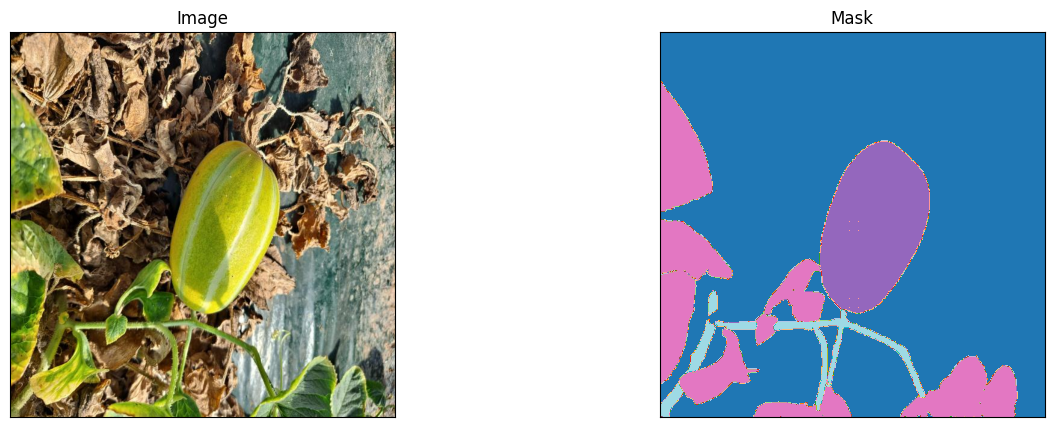

In [10]:
dataset = CustomSegmentationDataset(x_train_dir, y_train_dir)
image, mask = dataset[0]
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
visualize(image=image, mask=mask)

# [2] Augmentations